# Asteroid groups

Plot eccentricity ($e$) and inclination ($i$) versus semimajor axi ($a$) for main belt and other Mars/Jupiter 
asteroids including the Jupiter trojans to help emphasize asteroid groups. These plots use osculating orbit elements
from the MPC database

For asteroid collisional families (aka Hirayama families) see `Asteroid Families.ipynb` which use pre-computed proper
orbit elements.

In [2]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter

# astroquery

from astroquery.mpc import MPC
from astroquery.jplhorizons import Horizons

# suppress nuisance warnings

import warnings
warnings.filterwarnings('ignore',category=UserWarning, append=True)
warnings.filterwarnings('ignore',category=RuntimeWarning, append=True)

## Standard Plot Format

Setup the standard plotting format and make the plot.  

In [3]:
# graphic aspect ratio = width/height

aspect = 16.0/9.0 # wide-screen

#
# Don't change these unless you really need to (we never have)
#
# fPage is the horizontal fraction of the page occupied by the figure, default 1.0
#
# scaleFac is the LaTeX includegraphics scaling in units of \textwidth, default 1.0
#

fPage = 1.0
scaleFac = 0.85

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

figFmt = 'png'
dpi = 600
plotWidth = dpi*fPage*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 10
labelFontSize = 8
lwidth = 0.5
axisPad = 5
wInches = fPage*textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)
    
# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'16'})

# Font and line weight defaults for axes

matplotlib.rc('axes',linewidth=lwidth)
matplotlib.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']=f'{axisPad}'
plt.rcParams['ytick.major.pad']=f'{axisPad}'
plt.rcParams['axes.labelpad'] = f'{axisPad}'

# convenience function(s)

# semimajor axis of a p:q resonance for perturber with semimajor axis a_p

def a_pq(a_p,p,q):
    return a_p*(p/q)**(2./3.)


## Asteroid Data

Retrieve asteroid orbit elements from the Minor Planet Center Orbit database (MPCORB) using
`astroquery`.

### Main Belt

For the main belt we have to play a game because the maximum query allowed returns only 16k objects. We step in magnitude up to H=16, then H=16 in one query for the other families to retrive about 194k main belt asteroids with H<16mag

In [4]:
mbHmax = 13.8

result = MPC.query_objects('asteroid',
                           orbit_type=0,absolute_magnitude_max=mbHmax,
                           return_fields='semimajor_axis,eccentricity,inclination')

aMB = np.array([float(d.get('semimajor_axis',None)) for d in result])
eMB = np.array([float(d.get('eccentricity',None)) for d in result])
iMB = np.array([float(d.get('inclination',None)) for d in result])

limits = [[13.8,14.4],
          [14.4,14.75],
          [14.75,15.0],
          [15.0,15.2],
          [15.2,15.3],
          [15.3,15.4],
          [15.4,15.5],
          [15.5,15.6],
          [15.6,15.7],
          [15.7,15.8],
          [15.8,15.85],
          [15.85,15.9],
          [15.9,15.95],
          [15.95,16.0]
         ]

for Hlim in limits:
    result = MPC.query_objects('asteroid',
                               orbit_type=0,
                               absolute_magnitude_min=Hlim[0],
                               absolute_magnitude_max=Hlim[1],
                               return_fields='semimajor_axis,eccentricity,inclination')

    a2 = np.array([float(d.get('semimajor_axis',None)) for d in result])
    e2 = np.array([float(d.get('eccentricity',None)) for d in result])
    i2 = np.array([float(d.get('inclination',None)) for d in result])
    # print(f"{len(a2)} main belt asteroids with {Hlim[0]:.2f} < H < {Hlim[1]:.2f}")
    
    aMB = np.concatenate((aMB, a2), axis=None)
    eMB = np.concatenate((eMB, e2), axis=None)
    iMB = np.concatenate((iMB, i2), axis=None)

print(f"Retrieved {len(aMB)} Main Belt asteroids with H<16mag from the MPC")


Retrieved 193803 Main Belt asteroids with H<16mag from the MPC


### Hildas (3:2 resonance)

Uses MPC `orbit_type=8`

In [5]:
Hmax = 20 # mag

result = MPC.query_objects('asteroid',
                           orbit_type=8,absolute_magnitude_max=Hmax,
                           return_fields='semimajor_axis,eccentricity,inclination')

aH = np.array([float(d.get('semimajor_axis',None)) for d in result])
eH = np.array([float(d.get('eccentricity',None)) for d in result])
iH = np.array([float(d.get('inclination',None)) for d in result])

print(f"{len(aH)} Hildas H<{Hmax:.1f}mag")

6419 Hildas H<20.0mag


### Hungarias

Approximate mean-motion resonance with Jupiter of 9:2 and with Mars of 2:3

Uses MPC `orbit_type=6`

In [6]:
Hmax = 18.5

result = MPC.query_objects('asteroid',
                           orbit_type=6,absolute_magnitude_max=Hmax, 
                           return_fields='semimajor_axis,eccentricity,inclination')
                           
aHun = np.array([float(d.get('semimajor_axis',None)) for d in result])
eHun = np.array([float(d.get('eccentricity',None)) for d in result])
iHun = np.array([float(d.get('inclination',None)) for d in result])

print(f"{len(aHun)} Hungarias H<{Hmax:.1f}mag")

11251 Hungarias H<18.5mag


### Phocaea

Family of asteroids with inclinations of $i>$18 bounded by the $\nu_6$ and $\nu_5$ secular resonances
with Saturn

Uses MPC `orbit_type=7`

In [7]:
Hmax = 20.0
iMin = 18.0

result = MPC.query_objects('asteroid',
                           orbit_type=7,absolute_magnitude_max=Hmax, 
                           return_fields='semimajor_axis,eccentricity,inclination')
                           
a = np.array([float(d.get('semimajor_axis',None)) for d in result])
e = np.array([float(d.get('eccentricity',None)) for d in result])
i = np.array([float(d.get('inclination',None)) for d in result])

ip = np.where(i>iMin)[0]
aPho = a[ip]
ePho = e[ip]
iPho = i[ip]

print(f"{len(aPho)} Phocaeas H<{Hmax:.1f}mag")

7660 Phocaeas H<20.0mag


### Jupiter Trojans

Uses MPC `orbit_type=9`

In [8]:
Hmax = 18.5

result = MPC.query_objects('asteroid',
                           orbit_type=9,
                           absolute_magnitude_max=Hmax,
                           return_fields='semimajor_axis,eccentricity,inclination')

aT = np.array([float(d.get('semimajor_axis',None)) for d in result])
eT = np.array([float(d.get('eccentricity',None)) for d in result])
iT = np.array([float(d.get('inclination',None)) for d in result])

print(f"{len(aT)} Jupiter Trojans H<{Hmax:.1f}mag")

15417 Jupiter Trojans H<18.5mag


## Mars and Jupiter orbital data

Data from the NASA/JPL Solar System Dynamics database

In [9]:
aMars = 1.52364159 # au
eMars = 0.093476461967
iMars = 1.8475578 # degrees
PMars = 686.9459790/365.25 # years

qMars = aMars*(1-eMars)
QMars = aMars*(1+eMars)

aJup = 5.20288700 # au
eJup = 0.04838624
iJup = 1.30439695 # degrees
PJup = 4332.820129/365.25 # years

# semi-major axes of mean motion resonances with Jupiter

a32 = a_pq(aJup,2,3) # 3:2 etc
a41 = a_pq(aJup,1,4)
a31 = a_pq(aJup,1,3)
a21 = a_pq(aJup,1,2)
a52 = a_pq(aJup,2,5)
a73 = a_pq(aJup,3,7)
a74 = a_pq(aJup,4,7)

# plotting limits

aMin = 1.6 # au
aMax = 5.6 # 6.0 au

eMin = 0.0
eMax = 0.5

iMin = 0.0 # degrees
iMax = 40.0

## Make the plots

### eccentricity vs semimajor axis

Options:
 * `showKey=True` show the asteroid family key
 * `showMarsAphelion=True` to plot the line of asteroid perihelion = Mars aphelion (1.666au)

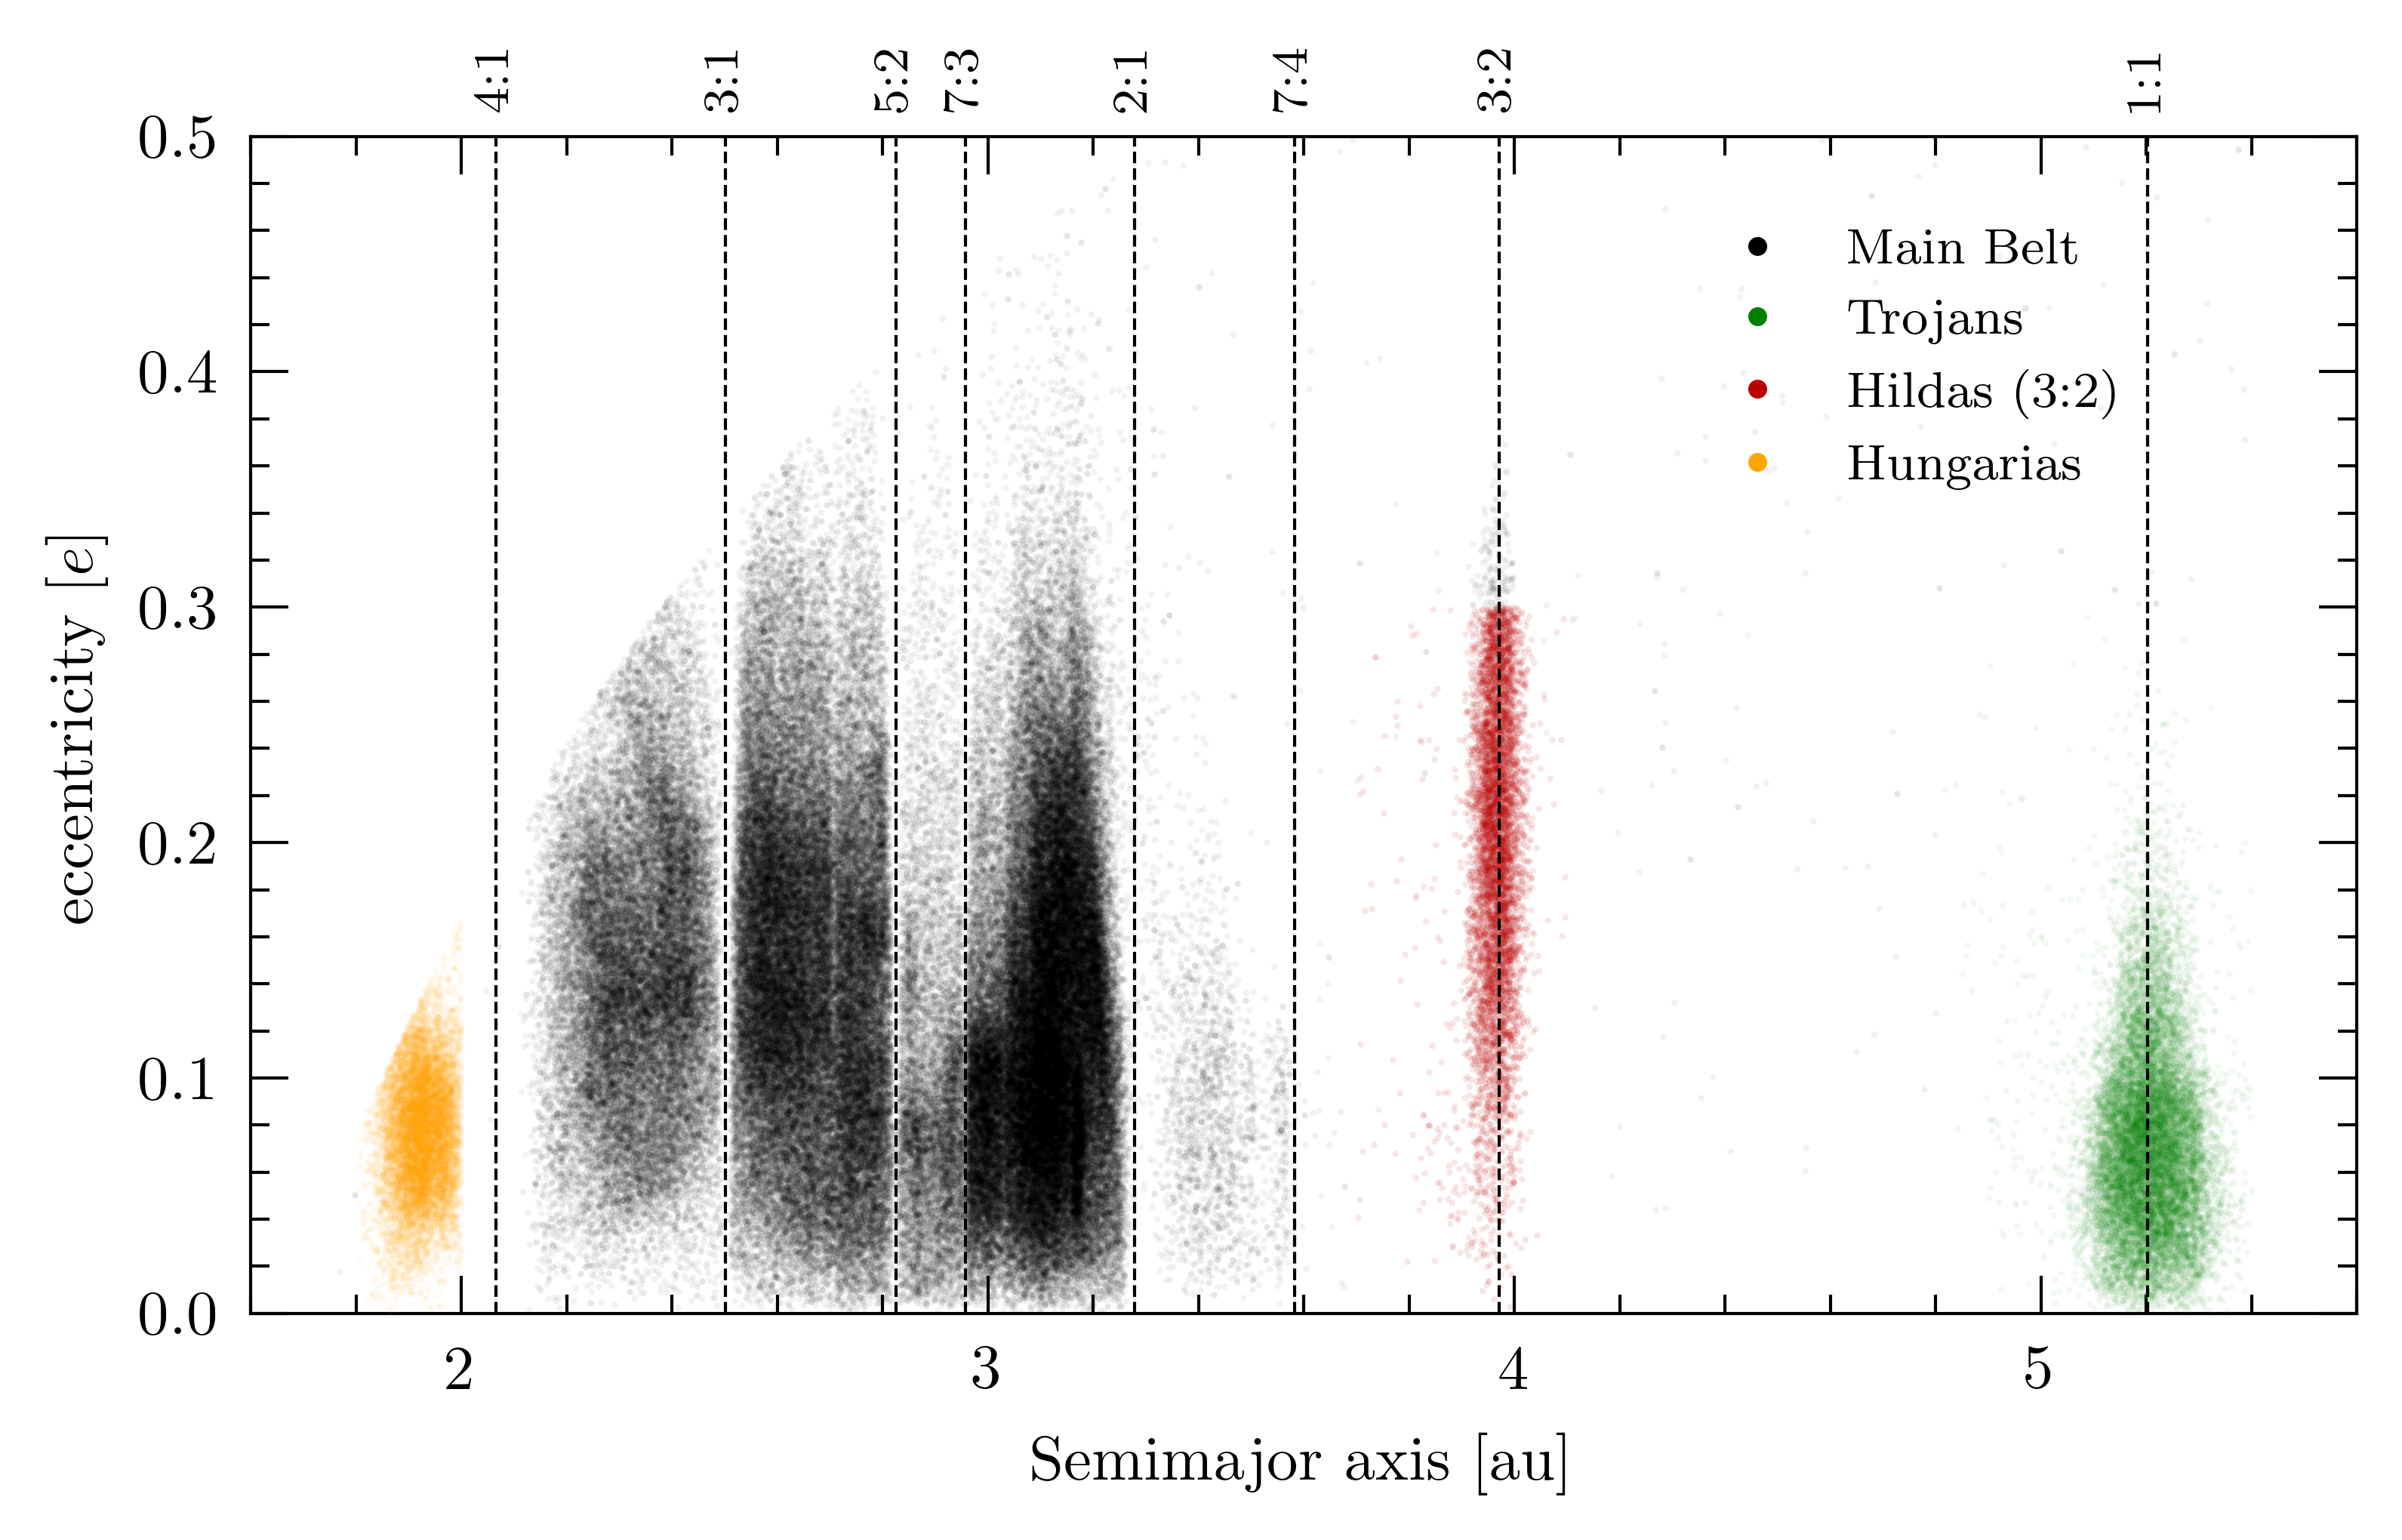

In [10]:
showKey = True
showMarsApo = False

if showMarsApo:
    plotFile = "Asteroids_ae_MarsApo.png"
else:
    plotFile = "Asteroids_ae.png"


fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

# Limits

ax.set_xlim(aMin,aMax)
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.set_xlabel(r'Semimajor axis [au]',fontsize=axisFontSize)

ax.set_ylim(eMin,eMax)
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.02))
ax.set_ylabel(r'eccentricity [$e$]',fontsize=axisFontSize)

# Asteroids as small semi-transparent back dots

ax.plot(aMB,eMB,'o',ms=1,mfc='black',mec=None,mew=0,alpha=0.05,zorder=8,label="Main Belt")

# Hildas, Hungarias, and Trojans

ax.plot(aT,eT,'o',ms=1,mfc='green',mec=None,mew=0,alpha=0.05,zorder=9,label="Trojans")
ax.plot(aH,eH,'o',ms=1,mfc='#bb0000',mec=None,mew=0,alpha=0.1,zorder=9,label="Hildas (3:2)")
ax.plot(aHun,eHun,'o',ms=1,mfc='orange',mec=None,mew=0,alpha=0.05,zorder=9,label="Hungarias")

#ax.plot(aPho,ePho,'o',ms=1,mfc='gold',mec=None,mew=0,alpha=0.05,zorder=9,label="Phocaeas")

# Jupiter mean-motion resonances (Trojans, Hildas, and the main Kirkwood gaps and main belt inner/outer edges at the 4:1 and 2:1)

ax.vlines([a32,a21,a31,a41,a52,a73,a74,aJup],eMin,eMax,ls=['--'],colors=['black'],lw=0.5,zorder=10)
ax.text(aJup,eMax+0.01,'1:1',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a32,eMax+0.01,'3:2',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a41,eMax+0.01,'4:1',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a31,eMax+0.01,'3:1',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a21,eMax+0.01,'2:1',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a52,eMax+0.01,'5:2',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a73,eMax+0.01,'7:3',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a74,eMax+0.01,'7:4',ha='center',va='bottom',fontsize=8,color='black',rotation=90)

# plot line of constant q = Q_mars (Mars aphelion)

if showMarsApo:
    aq = np.linspace(QMars,aMax,101)
    eq = 1.0 - (QMars/aq)
    ax.plot(aq,eq,':',color='blue',lw=0.75,zorder=10,label=r'q$_{\rm a}$=Mars aphelion')
    ax.plot(QMars,0.001,'o',mec="#c1440e",mfc="#c1440e",ms=4,mew=0.2,zorder=10)
    ax.text(QMars,-0.005,'Mars\naphelion',ha='center',va='top',fontsize=6,color='#c1440e')
    
# ident key

if showKey:
    leg = ax.legend(loc="upper right",bbox_to_anchor=(0.91,0.96),frameon=False,prop={'size':8},facecolor='white')
    for handle in leg.legend_handles:
        handle.set_markersize(3)
        handle.set_alpha(1.0)

# hardcopy 

plt.savefig(plotFile,bbox_inches='tight',facecolor='white')

plt.show()

### inclination vs semimajor axis

Option
 * `showKey=True` show the asteroid family key 

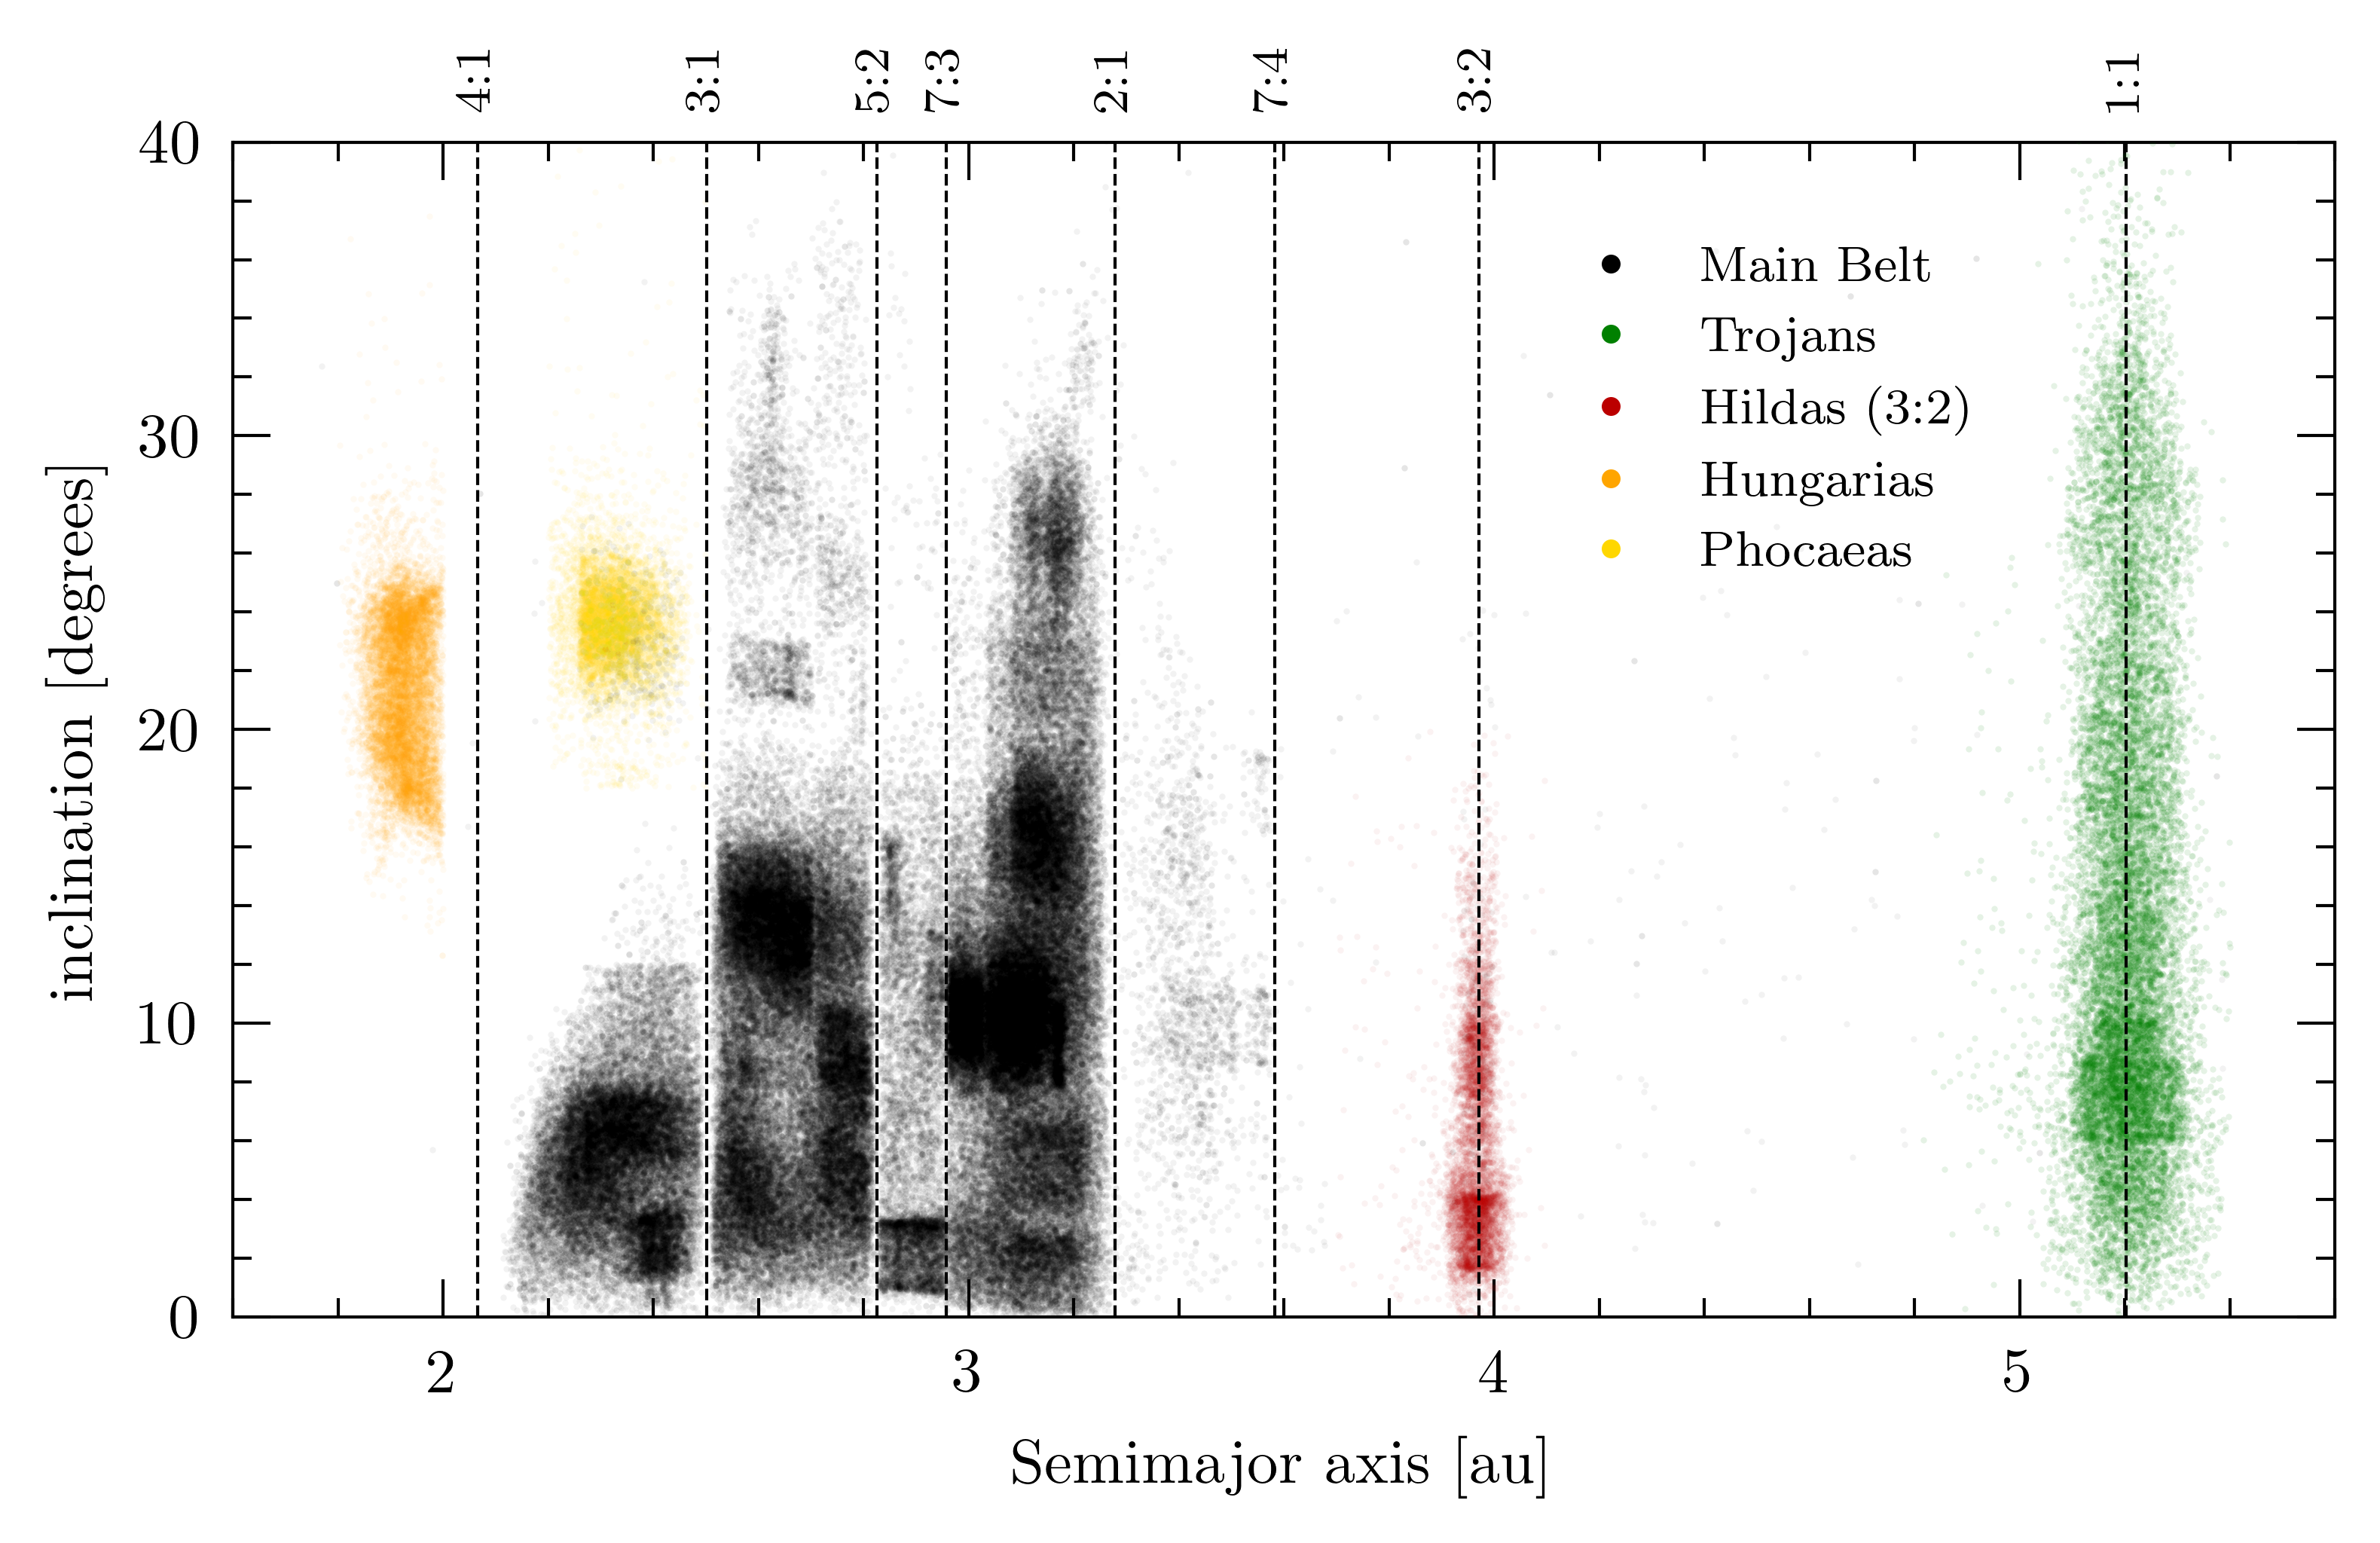

In [96]:
plotFile = "Asteroids_ai.png"
showKey = True

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

# Limits

ax.set_xlim(aMin,aMax)
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.set_xlabel(r'Semimajor axis [au]',fontsize=axisFontSize)

ax.set_ylim(iMin,iMax)
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.set_ylabel(r'inclination [degrees]',fontsize=axisFontSize)

# Asteroids as small semi-transparent back dots

ax.plot(aMB,iMB,'o',ms=1,mfc='black',mec=None,mew=0,alpha=0.05,zorder=8,label="Main Belt")

# Hildas, Hungarias, and Trojans

ax.plot(aT,iT,'o',ms=1,mfc='green',mec=None,mew=0,alpha=0.1,zorder=9,label="Trojans")
ax.plot(aH,iH,'o',ms=1,mfc='#bb0000',mec=None,mew=0,alpha=0.05,zorder=9,label="Hildas (3:2)")
ax.plot(aHun,iHun,'o',ms=1,mfc='orange',mec=None,mew=0,alpha=0.05,zorder=9,label="Hungarias")

ax.plot(aPho,iPho,'o',ms=1,mfc='gold',mec=None,mew=0,alpha=0.05,zorder=9,label="Phocaeas")

# Jupiter mean-motion resonances (Trojans, Hildas, and the main Kirkwood gaps and main belt inner/outer edges at the 4:1 and 2:1)

ax.vlines([a32,a21,a31,a41,a52,a73,a74,aJup],iMin,iMax,ls=['--'],colors=['black'],lw=0.5,zorder=10)
ax.text(aJup,iMax+1,'1:1',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a32,iMax+1,'3:2',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a41,iMax+1,'4:1',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a31,iMax+1,'3:1',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a21,iMax+1,'2:1',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a52,iMax+1,'5:2',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a73,iMax+1,'7:3',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a74,iMax+1,'7:4',ha='center',va='bottom',fontsize=8,color='black',rotation=90)

# ident key

if showKey:
    leg = ax.legend(loc="upper right",bbox_to_anchor=(0.85,0.95),frameon=False,prop={'size':8},facecolor='white')
    for handle in leg.legend_handles:
        handle.set_markersize(3)
        handle.set_alpha(1.0)
        
# hardcopy 

plt.savefig(plotFile,bbox_inches='tight',facecolor='white')

plt.show()